In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy as sp
from scipy.optimize import minimize
from scipy.stats import norm
from scipy.stats import chi2
import cython

from KalmanFilter import KalmanFilter
from KF_py import KalmanFilter as KF
%load_ext autotime
%load_ext Cython

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython
time: 13.5 ms


We'll first estimate the local level model giving us the chance of writing the Kalman filter algorithm which, if there's time, can be re-used for the DSGE model.

# The Model

as described in the chapter 4 in Koopman et al. The local level model with a seasonal component consists of the following equations:

$$y_t = \mu_t + \gamma_t + \epsilon_t, \qquad \epsilon_t \sim NID(0,\sigma^2_\epsilon)$$

$$\mu_{t+1} = \mu_t + \xi_t, \qquad \xi_t \sim NID(0,\sigma^2_\xi) $$

$$\gamma_{t+1} = -\gamma_{t} - \gamma_{t-1} - \theta_1\gamma_{t-2} + \omega_t \sim NID(0,\sigma^2_\omega) $$


We added a $\theta$ coefficient in order to use maximum likelihood estimation

## State Space Form

General Form:

$$ y_t = Z x_t + \epsilon_t, \qquad \epsilon_t \sim NID(0,\sigma^2_\epsilon)$$
$$ x_{t+1} = T x_t + R_t \eta_T, \qquad \eta_t \sim NID(0,Qt) $$

In terms of the model:
$$ 
x_t = 
\begin{pmatrix}\mu_t \\ \gamma_t  \\  \gamma_{t-1}   \\ \gamma_{t-2}  \end{pmatrix}
$$

$$
\eta_t = 
\begin{pmatrix}\xi_t \\ \omega_t \end{pmatrix}
$$

$$
T_t = 
\begin{bmatrix} 
1 & 0 & 0 & 0 \\
0 & -1 & -1 & -\theta_1 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 
\end{bmatrix}
$$


$$
Z^T_t = 
\begin{pmatrix}1 \\ 1  \\  0   \\ 0  \end{pmatrix}
$$

$$
Q_t = 
\begin{bmatrix} 
\sigma^2_\xi & 0 \\
0 & \sigma^2_\omega \\
\end{bmatrix}
$$

$$
R_t = 
\begin{bmatrix} 
1 & 0  \\
0 & 1  \\
0 & 0  \\
0 & 0  \\
\end{bmatrix}
$$

# Generating the data for $\theta_1=1$

We have to choose all parameter values plus the initial states

$$\gamma_t = \gamma_{t-1} = \gamma_{t-2} = 0$$
$$\theta_1 = 0.7$$
$$\sigma^2_\xi = 2$$
$$\omega^2_\zeta = 0.2$$
$$\sigma^2_\epsilon = 0.3$$

$$y_t = \mu_t + \gamma_t + \epsilon_t, \qquad \epsilon_t \sim NID(0,\sigma^2_\epsilon)$$

$$\mu_{t+1} = \mu_t + \xi_t, \qquad \xi_t \sim NID(0,\sigma^2_\xi) $$

$$\gamma_{t+1} = -\gamma_{t} - \gamma_{t-1} - \theta_1\gamma_{t-2} + \omega_t \sim NID(0,\sigma^2_\omega) $$


In [4]:
n = 1000
theta1 = 0.7
sigmaXi = 0.1
sigmaOmega = 0.2
sigmaEpsilon = 0.3

time: 3.66 ms


In [5]:
y = np.array([0])
mi = np.array([0])
gamma = np.array([0])

xi = np.array([0])
omega = np.array([0])
ep = np.array([0])

for i in range(1,n):

    # Level equation
    xi = np.append(xi,np.random.normal(scale=sigmaXi))
    mi = np.append(mi,mi[i-1]+xi[i])
    
    # Seasonality equation
    omega = np.append(omega,np.random.normal(scale=sigmaOmega))
    holder = 0
    if i-1 >= 0:
        holder -= gamma[i-1] 
    if i-2 >= 0:
        holder -= gamma[i-2] 
    if i-3 >= 0:
        holder -= gamma[i-3] * theta1
    
    gamma = np.append(gamma,holder+omega[i])
    
    # Series equation
    ep = np.append(ep,np.random.normal(scale=sigmaEpsilon))
    y = np.append(y,mi[i]+gamma[i]+ep[i])

y = pd.DataFrame(y) 
mi = pd.DataFrame(mi) 
gamma = pd.DataFrame(gamma) 

time: 193 ms


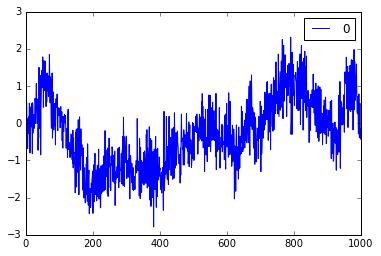

time: 376 ms


In [6]:
y.plot()

## Filtering States

In [7]:
T = pd.DataFrame([
        [1,0,0,0],
        [0,-1,-1,-1],
        [0,1,0,0],
        [0,0,1,0],
    ])
T

,0,1,2,3
0,1,0,0,0
1,0,-1,-1,-1
2,0,1,0,0
3,0,0,1,0


time: 20.8 ms


In [8]:
Z = pd.DataFrame([
        [1,1,0,0],
    ])
Z

,0,1,2,3
0,1,1,0,0


time: 18.6 ms


In [9]:
R = pd.DataFrame([
        [1,0],
        [0,1],
        [0,0],
        [0,0],
    ])
R

,0,1
0,1,0
1,0,1
2,0,0
3,0,0


time: 19.4 ms


In [10]:
H = pd.DataFrame([0.3])
H

,0
0,0.3


time: 12 ms


In [11]:

Q = pd.DataFrame([
        [0.1,0],
        [0,0.2],
    ])
Q

,0,1
0,0.1,0.0
1,0.0,0.2


time: 13 ms


In [12]:
a1 = pd.DataFrame([0,0,0,0])
a1

,0
0,0
1,0
2,0
3,0


time: 13.5 ms


In [13]:
P1 = pd.DataFrame(np.diag([1,1,1,1]))
P1

,0,1,2,3
0,1,0,0,0
1,0,1,0,0
2,0,0,1,0
3,0,0,0,1


time: 13.9 ms


In [14]:
kf = KalmanFilter(y=y, Z=Z, H=H, T=T, Q=Q, a1=a1, P1=P1, R=R, nStates=4)
kf.runFilter()

time: 524 ms


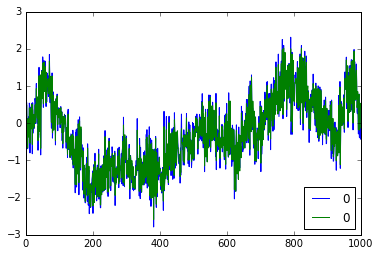

time: 393 ms


In [15]:
pd.concat([kf.y , kf.yhat],axis=1).plot()

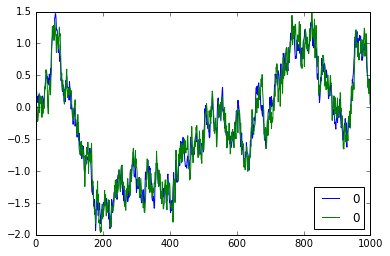

time: 462 ms


In [16]:
pd.concat([mi , kf.a[0]],axis=1).plot()

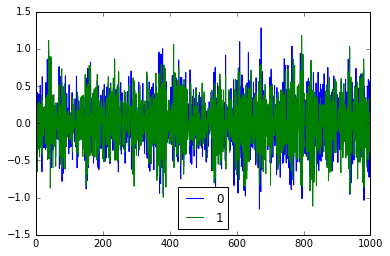

time: 560 ms


In [17]:
pd.concat([gamma , kf.a[1]],axis=1).plot()

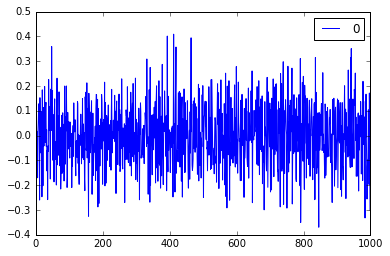

time: 457 ms


In [18]:
(kf.y-kf.yhat).plot()

# Maximum likelihood estimates

## Generating the data for $\theta_1=0.3$

We have to choose all parameter values plus the initial states

$$\gamma_t = \gamma_{t-1} = \gamma_{t-2} = 0$$
$$\theta_1 = 0.7$$
$$\sigma^2_\xi = 2$$
$$\omega^2_\zeta = 0.2$$
$$\sigma^2_\epsilon = 0.3$$

$$y_t = \mu_t + \gamma_t + \epsilon_t, \qquad \epsilon_t \sim NID(0,\sigma^2_\epsilon)$$

$$\mu_{t+1} = \mu_t + \xi_t, \qquad \xi_t \sim NID(0,\sigma^2_\xi) $$

$$\gamma_{t+1} = -\gamma_{t} - \gamma_{t-1} - \theta_1\gamma_{t-2} + \omega_t \sim NID(0,\sigma^2_\omega) $$


In [19]:
n = 150
theta1 = 0.7
sigmaXi = 0.1
sigmaOmega = 0.2
sigmaEpsilon = 0.3

time: 3.45 ms


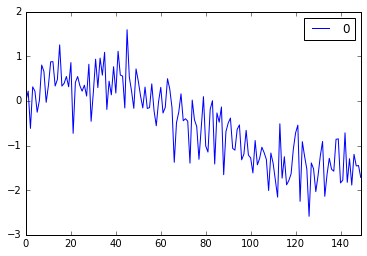

time: 517 ms


In [20]:
y = np.array([0])
mi = np.array([0])
gamma = np.array([0])

xi = np.array([0])
omega = np.array([0])
ep = np.array([0])

for i in range(1,n):

    # Level equation
    xi = np.append(xi,np.random.normal(scale=sigmaXi))
    mi = np.append(mi,mi[i-1]+xi[i])
    
    # Seasonality equation
    omega = np.append(omega,np.random.normal(scale=sigmaOmega))
    holder = 0
    if i-1 >= 0:
        holder -= gamma[i-1] 
    if i-2 >= 0:
        holder -= gamma[i-2] 
    if i-3 >= 0:
        holder -= gamma[i-3] * theta1
    
    gamma = np.append(gamma,holder+omega[i])
    
    # Series equation
    ep = np.append(ep,np.random.normal(scale=sigmaEpsilon))
    y = np.append(y,mi[i]+gamma[i]+ep[i])

y = pd.DataFrame(y) 
mi = pd.DataFrame(mi) 
gamma = pd.DataFrame(gamma) 

y.plot()

$$
T_t = 
\begin{bmatrix} 
1 & 0 & 0 & 0 \\
0 & -1 & -1 & -\theta_1 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 
\end{bmatrix}
$$



In [21]:
def wrapper(theta):
    T = pd.DataFrame([
        [1,0,0,0],
        [0,-1,-1,-theta[0]],
        [0,1,0,0],
        [0,0,1,0],
    ])

    H = pd.DataFrame([theta[1]])

    Q = pd.DataFrame([
        [theta[2],0],
        [0,theta[3]],
    ])

    kf = KalmanFilter(y=y, 
                      Z=Z.astype(float), 
                      H=H.astype(float), 
                      T=T.astype(float), 
                      Q=Q.astype(float), 
                      a1=a1.astype(float), 
                      P1=P1.astype(float), 
                      R=R.astype(float), 
                      nStates=4)    

    return -np.log(kf.likelihood())


time: 22.1 ms


In [22]:
%timeit
KalmanFilter(y=y, Z=Z, H=H, T=T, Q=Q, a1=a1, P1=P1, R=R, nStates=4).likelihood()

8.6490517168450404e-75

time: 118 ms


In [23]:
import pyximport; pyximport.install()
# from KalmanFilter_Cython2 import KalmanFilter as KalmanFilterCy2
# from KalmanFilter_Cython import KalmanFilter as KalmanFilterCy

(None, <pyximport.pyximport.PyxImporter at 0x11465a9b0>)

time: 9.55 ms


In [24]:
# %timeit
# KalmanFilterCy(y=y, Z=Z, H=H, T=T, Q=Q, a1=a1, P1=P1, R=R, nStates=4).likelihood()

time: 1.29 ms


In [25]:
# %timeit
# KalmanFilterCy2(y=y, Z=Z, H=H, T=T, Q=Q, a1=a1, P1=P1, R=R, nStates=4).likelihood()

time: 1.38 ms


In [24]:
# minimize(wrapper,np.array([0.0,1.0,1.0,1.0]), options={'disp':True, 'maxiter':100}, method='BFGS')

# minimize(wrapper,np.array([0.0,1.0,1.0,1.0]), 
#          options={'disp':True, 'maxiter':200}, 
#          bounds = ((-5,5),(0,5),(0,5),(0,5),), 
#          method='SLSQP',
#          )

minimize(wrapper,np.array([0.0,1.0,1.0,1.0]), 
         options={'disp':True, 'maxiter':500}, 
#          bounds = ((-5,5),(None,None),(None,None),(None,None),), 
         method='SLSQP',
         )

# minimize(wrapper,np.array([0.0,1.0,1.0]), 
#          options={'disp':True, 'maxiter':1000}, 
#          bounds = ((0,2),(0,2),(0,2),),
#          method='SLSQP')

KeyboardInterrupt: 

# Bayesian Estimates

## Metropolis Hastings

---
**Metropolis-Hastings Algoritm**

Guess $\theta^{(0)}$ and for $i=0$ until $n$: 
1. $\theta=\theta^{(i)}$
Draw $\theta'\sim q(\theta'|\theta)$
2. Compute $r=\min(1,\alpha)$ where $\alpha= \frac{p(\theta')q(\theta|\theta')}{p(\theta)q(\theta'|\theta)}$
4. Draw $u\sim U(0,1)$
5. $\theta^{(i+1)}=\begin{cases}\theta' & \text{if $u<r$}\\\theta & \text{if $u\geq r$}\end{cases}$

---

In [26]:
def wrapper(theta):
    T = pd.DataFrame([
        [1,0,0,0],
        [0,-1,-1,-theta[0]],
        [0,1,0,0],
        [0,0,1,0],
    ])

    H = pd.DataFrame([theta[1]])

    Q = pd.DataFrame([
        [theta[2],0],
        [0,theta[3]],
    ])

    kf = KalmanFilter(y=y, 
                      Z=Z.astype(float), 
                      H=H.astype(float), 
                      T=T.astype(float), 
                      Q=Q.astype(float), 
                      a1=a1.astype(float), 
                      P1=P1.astype(float), 
                      R=R.astype(float), 
                      nStates=4,
                     performChecks=False)    

    return kf.likelihood()


time: 23.4 ms


In [27]:
def wrapper2(theta):
    T = pd.DataFrame([
        [1,0,0,0],
        [0,-1,-1,-theta[0]],
        [0,1,0,0],
        [0,0,1,0],
    ])

    H = pd.DataFrame([theta[1]])

    Q = pd.DataFrame([
        [theta[2],0],
        [0,theta[3]],
    ])

    kf = KF(y=np.array(y), 
                      Z=np.array(Z.astype(float)), 
                      H=np.array(H.astype(float)), 
                      T=np.array(T.astype(float)), 
                      Q=np.array(Q.astype(float)), 
                      a1=np.zeros((4)), 
                      P1=np.identity(4), 
                      R=np.array(R.astype(float)), 
                      nStates=4,)    

    return kf['ll']



time: 29 ms


In [28]:
def posterior(theta,priorMeans, priorVariances):
    
    i=0
    temp = norm.pdf(theta[i],priorMeans[i],priorVariances[i])
    for i in range(1,3+1):
        temp *= chi2.pdf(theta[i],1)
    
    ll = wrapper(theta)
#     print(ll)
    return ll * temp

time: 8.27 ms


In [29]:
def posterior2(theta,priorMeans, priorVariances):
    
    i=0
    temp = norm.pdf(theta[i],priorMeans[i],priorVariances[i])
    for i in range(1,3+1):
        temp *= chi2.pdf(theta[i],1)
    
    ll = wrapper2(theta)
#     print(ll)
    return ll * temp

time: 5.54 ms


In [30]:
%%timeit -n 1

sample = 2000

thetaMH = []
accept = np.zeros([sample])
posts = np.zeros([sample])

thetaMH.append(np.array([1,0.1,0.1,0.1,]))

thetastemps = []
disturbances = []
sigma = 0.3
sigmas = np.array([0.1,sigma,sigma,sigma])


priorMeans = np.array([0,0,0,0])

priorVariances = 3 * np.ones(4)

for i in range(1,sample):
    disturbance = np.multiply(np.random.randn(thetaMH[0].shape[0]),sigmas)
#     disturbance[1:] = np.exp(disturbance[1:]) #problema está aqui
#     print(disturbance)
    thetaTemp = thetaMH[i-1].copy()
    thetaTemp[1:] = np.log(thetaMH[i-1][1:])+disturbance[1:]
    thetaTemp[1:] = np.exp(thetaTemp[1:])
    thetaTemp[0] = thetaTemp[0] + disturbance[0]
    disturbances.append(disturbance)
    thetastemps.append(thetaTemp.copy())
#     print(thetaTemp)
#     print(thetastemps[i-1])
#     thetaTemp = (temp)
    tempPost = posterior(thetaTemp,priorMeans, priorVariances)
    lalpha = np.log(tempPost) - np.log(posts[i-1])
    r = np.min([1, np.exp(lalpha)])
    
    u = np.random.uniform()
    
    if u < r:
        accept[i] = 1
        thetaMH.append(thetaTemp)
        posts[i] = tempPost
    else:
        thetaMH.append(thetaMH[i-1])
        posts[i] = posts[i-1]    
        
post = pd.DataFrame(thetaMH)

1 loop, best of 3: 2min 54s per loop
time: 10min 3s


In [31]:
%%timeit -n 1

sample = 2000

thetaMH = []
accept = np.zeros([sample])
posts = np.zeros([sample])

thetaMH.append(np.array([1,0.1,0.1,0.1,]))

thetastemps = []
disturbances = []
sigma = 0.3
sigmas = np.array([0.1,sigma,sigma,sigma])


priorMeans = np.array([0,0,0,0])

priorVariances = 3 * np.ones(4)

for i in range(1,sample):
    disturbance = np.multiply(np.random.randn(thetaMH[0].shape[0]),sigmas)
#     disturbance[1:] = np.exp(disturbance[1:]) #problema está aqui
#     print(disturbance)
    thetaTemp = thetaMH[i-1].copy()
    thetaTemp[1:] = np.log(thetaMH[i-1][1:])+disturbance[1:]
    thetaTemp[1:] = np.exp(thetaTemp[1:])
    thetaTemp[0] = thetaTemp[0] + disturbance[0]
    disturbances.append(disturbance)
    thetastemps.append(thetaTemp.copy())
#     print(thetaTemp)
#     print(thetastemps[i-1])
#     thetaTemp = (temp)
    tempPost = posterior2(thetaTemp,priorMeans, priorVariances)
    lalpha = np.log(tempPost) - np.log(posts[i-1])
    r = np.min([1, np.exp(lalpha)])
    
    u = np.random.uniform()
    
    if u < r:
        accept[i] = 1
        thetaMH.append(thetaTemp)
        posts[i] = tempPost
    else:
        thetaMH.append(thetaMH[i-1])
        posts[i] = posts[i-1]    
        
post = pd.DataFrame(thetaMH)

1 loop, best of 3: 1min 30s per loop
time: 5min 21s


In [32]:
burn=500

time: 2.04 ms


In [33]:
accept.sum() / accept.shape[0]

NameError: name 'accept' is not defined

time: 23.7 ms


In [ ]:
parameter = 0

In [ ]:
post[parameter].iloc[burn:].median()

In [ ]:
post[parameter].iloc[burn:].mean()

In [ ]:
post[parameter].iloc[burn:].plot.density()

In [ ]:
parameter = 1

In [ ]:
post[parameter].iloc[burn:].median()

In [ ]:
post[parameter].iloc[burn:].mean()

In [ ]:
post[parameter].iloc[burn:].plot.density()

In [ ]:
parameter = 2

In [ ]:
post[parameter].iloc[burn:].median()

In [ ]:
post[parameter].iloc[burn:].mean()

In [ ]:
post[parameter].iloc[burn:].plot.density()